In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a first attempt to read in track information and use it to predict the the full target histrograms.

It will read in the TracksToDKE__Ellipsoids_DDPlus model to predict the KDE, and then feed it into a SimpleCNN model to predict the target histograms.  Initially, it will use previously trained weights.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Fri Jan 15 20:06:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   35C    P8    39W / 250W |  10778MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 150

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
## 50 epochs using 4 of Will's files with batch_size = 48 should take
##  just over 8 hours
folder = '15Jan2021_TracksToHists_B_Iter12Bb_150epochs_lr_1p5em5_b48_2p5_kde2hists_float_all_4x_will'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
## reduce batch size from 64 to 32 when floating all the parameters
##  it *appears* that storing the gradients requires extra memory
##  batch_size = 32 --> 6623MiB / 11019 MiB on sleepy RTX2081 Ti
batch_size = 48
# How fast to learn
## learning rate was 1e-7 for all layers in TracksToHists_A
## here we want to learn only weights in the finalFilter layer
## of TracksToHists_B, so try a high learning rate, at least initially
## 1e-3 did well for the first 10 epochs; let's increase it for the next 40
## reduce to 1e-3 for iteration with KDE_to_Hists weights floated
##  cost decreased monotonically in previous run, so increase lr to 2e-3
##  tried running with lr = 2e-3 and the validation cost function 
##  bounced around.  Want to try using a lower learning rate and
##  a larger training sample
##  Iter5B --  float all, leave learning rate = 5e-4
##  Iter6C, with lr = 1e-5 rather than 1e-6, seems to be learning more quickly,
##  so increase the learning rate to 1e-5 for Iter7B
learning_rate = 1.5e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_t2hists import collect_t2hists_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
## from model.kde_loss_B import Loss  ## Tracks_to_KDE loss, not for target hists

##  "standard" ratios loss for hists training
from model.alt_loss_A import Loss  ## loss used to train RunModel_Demo_28November2020-SimpleCNNLayer_Ca-Restart_5


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as t2kde_model
##from model.models_mds_G import SimpleCNN5Layer_Ca as kde2hists_model
from model.models_mds_28Dec20 import SimpleCNN5Layer_Ca as kde2hists_model  ## copy of models_mds_01June20 for debugging
from model.models_t2hists import TracksToHists_B as t2hists_model


##from model.training_kde import trainNet, select_gpu, Results
## training_t2hists_A.py increases "difference" for accepting found
## peaks as matched from 5 bins to 7.5 bins (compmared to original training.py)
from model.training_t2hists_A import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(1)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## 210109 let's use some of Will's toy MC for training rather than the 20K sample I've been using

##train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
train_loader = collect_t2hists_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                    '/share/lazy/will/data/June30_2020_80k_2.h5',
                                    '/share/lazy/will/data/June30_2020_80k_3.h5',
                                    '/share/lazy/will/data/June30_2020_80k_4.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
##                             slice = slice(0,18000)
                           )



                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,

## 210109 and use everything in this 20K file for validation
val_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
##                           slice = slice(18000,None)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
len(X) =  80000
len(Xlist) =  1
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 107.2 s
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  222
len(pocaMx[1]) =  133
len(pocaMx[2]) =  259
len(pocaMx[3]) =  114
len(pocaMx[4]) =  143
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 222
 iEvt, nTrks =  1 133
 iEvt, nTrks =  2 259
 iEvt, nTrks =  3 114
 iEvt, nTrks =  4 143
 iEvt, nTrks =  5 136
 iEvt, nTrks =  6 397
 iEvt, nTrks =  7 370
 iEvt, nTrks =  8 97
 iEvt, nTrks =  9 67
len(X) =  80000
len(Xlist) =  2
Loa

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model_t2kde = t2kde_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model_kde2hists = kde2hists_model()
model_t2hists = t2hists_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa

## 210110 For Iter0, freeze all weights other than those asociated with
## the finalFilter added in moving from TracksToHists_A to TracksToHists_B

## for "float_KDE_to_Hists" loop over ct<17
## for float_all loope over ct < 0
ct = 0
for child in model_t2hists.children():
  print('ct, child = ',ct, "  ", child)
  if (ct < 0) :
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1

loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model_t2hists.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
## want to look at all three dictionaries to start:
##  t2kde
##  kde2hists
##  t2hists
## the plan is to (initially) copy weights from separate dictionaries into th t2hists dictionary

##   ML -> /share/lazy/sokoloff/ML
'''
model_t2kde_dict = model_t2kde.state_dict()
## mds 190725 for debugging
print("for model_t2kde_dict")
index = 0
for k,v in model_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_kde2hists_dict = model_kde2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_t2hists_dict = model_t2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_t2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#

##  build the "updated_dict" to become the t2hists_dictionary from the
##  t2kde and kde2hist dictionaries
update_dict = model_t2hists_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''


'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''

'''
##model_t2hists.load_state_dict(updated_dict,strict=False)

##model__t2hists_dict = model_t2hists.state_dict()

## let's get the tracks-to-kde model here
t2kde_folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
t2kde_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
t2kde_name = t2kde_folder
suffix = 'final'
t2kde_dict_name = 'ML/' + t2kde_folder + '/' + t2kde_name + '_'+ suffix + '.pyt'
print('t2kde_dict_name = ',t2kde_dict_name)
pretrained_t2kde_dict = torch.load(t2kde_dict_name)

print(" \n","  for t2kde_pretrained_dict")
index = 0
for k,v in pretrained_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
    
## let's get the hists-to-kde model here   
kde2hists_folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
kde2hists_name = kde2hists_folder
suffix = 'final'
kde2hists_dict_name = 'ML/' + kde2hists_folder + '/' + kde2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_kde2hists_dict = torch.load(kde2hists_dict_name)

print(" \n","  for kde2hists_pretrained_dict")
index = 0
for k,v in pretrained_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 


##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_t2kde_dict.items() if k in model_t2hists_dict}
## mds dec28 print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_t2hists_dict.update(pretrained_dict) 

update_dict["hist_conv1.weight"] = pretrained_kde2hists_dict["conv1.weight"]
update_dict["hist_conv1.bias"]   = pretrained_kde2hists_dict["conv1.bias"]
update_dict["hist_conv2.weight"] = pretrained_kde2hists_dict["conv2.weight"]
update_dict["hist_conv2.bias"]   = pretrained_kde2hists_dict["conv2.bias"]
update_dict["hist_conv3.weight"] = pretrained_kde2hists_dict["conv3.weight"]
update_dict["hist_conv3.bias"]   = pretrained_kde2hists_dict["conv3.bias"]
update_dict["hist_conv4.weight"] = pretrained_kde2hists_dict["conv4.weight"]
update_dict["hist_conv4.bias"]   = pretrained_kde2hists_dict["conv4.bias"]
update_dict["hist_conv5.weight"] = pretrained_kde2hists_dict["conv5.weight"]
update_dict["hist_conv5.bias"]   = pretrained_kde2hists_dict["conv5.bias"]
update_dict["hist_fc1.weight"]   = pretrained_kde2hists_dict["fc1.weight"]
update_dict["hist_fc1.bias"]     = pretrained_kde2hists_dict["fc1.bias"]

##model_t2hists.update(update_dict,strict=False)
model_t2hists.load_state_dict(update_dict,strict=False)
model_t2hists_dict = model_t2hists.state_dict()
'''

##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

t2hists_folder = '15Jan2021_TracksToHists_B_Iter11Bb_50epochs_lr_1p5em5_b48_2p5_kde2hists_float_all_4x_will'
t2hists_name = t2hists_folder
suffix = 'final'
t2hists_dict_name = 'ML/' + t2hists_folder + '/' +t2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_t2hists_dict = torch.load(t2hists_dict_name) 

model_t2hists.load_state_dict(pretrained_t2hists_dict,strict=False)

##  print('model_t2hists_dict =    ', model_t2hists_dict)


<All keys matched successfully>

In [12]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [13]:
model = model_t2hists.to(device)

<IPython.core.display.Javascript object>


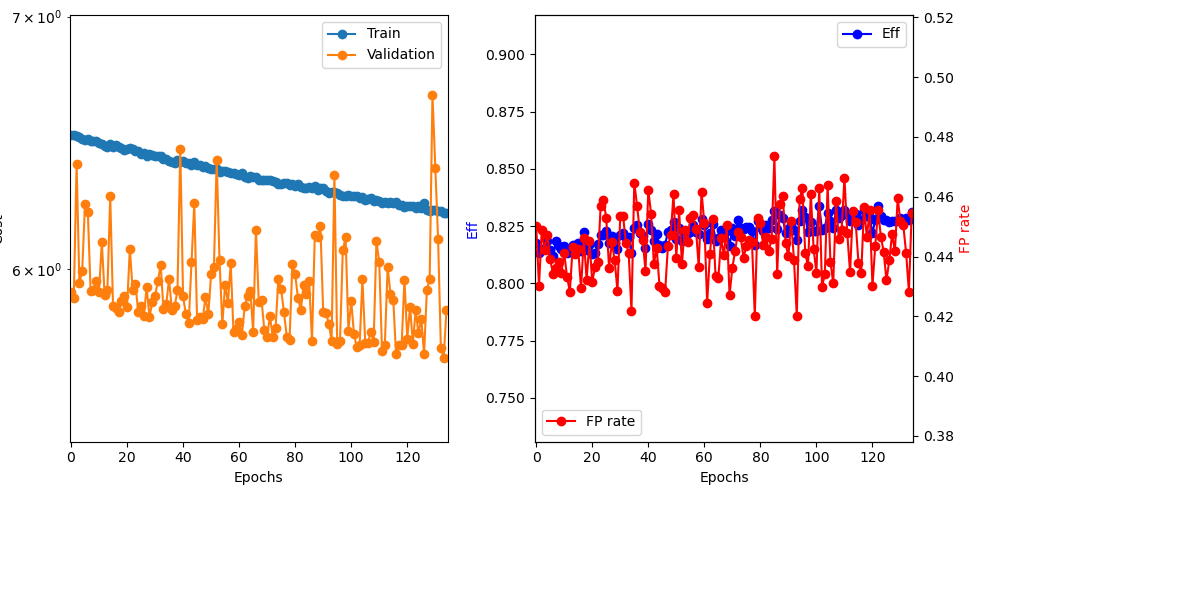

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [ ]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
##    print("xs = ",xs)
    
    # Update the plot above
##    print("results.index = ",results.index,"  results.cost", results.cost)
##    print("results.index = ",results.index,"  results.val", results.val)
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.95, max_cost*1.05)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 6667, val = 417


Epoch 0: train=6.51436, val=5.9169, took 597.51 s
  Validation Found 88344 of 108024, added 9004 (eff 81.78%) (0.45 FP/event)


Epoch 1: train=6.51051, val=5.89574, took 599.11 s
  Validation Found 87861 of 108024, added 8604 (eff 81.33%) (0.43 FP/event)


Epoch 2: train=6.50798, val=6.39734, took 599.15 s
  Validation Found 88033 of 108024, added 8980 (eff 81.49%) (0.449 FP/event)


Epoch 3: train=6.50343, val=5.94967, took 595.02 s
  Validation Found 88038 of 108024, added 8843 (eff 81.50%) (0.442 FP/event)


Epoch 4: train=6.49484, val=5.99559, took 592.82 s
  Validation Found 88408 of 108024, added 8945 (eff 81.84%) (0.447 FP/event)


Epoch 5: train=6.4945, val=6.24369, took 592.24 s
  Validation Found 88005 of 108024, added 8783 (eff 81.47%) (0.439 FP/event)


Epoch 6: train=6.49523, val=6.2149, took 591.36 s
  Validation Found 87724 of 108024, added 8683 (eff 81.21%) (0.434 FP/event)


Epoch 7: train=6.49034, val=5.92239, took 591.16 s
  Validation Found 88404 of 108024, added 8723 (eff 81.84%) (0.436 FP/event)


Epoch 8: train=6.48903, val=5.9256, took 591.58 s
  Validation Found 88206 of 108024, added 8763 (eff 81.65%) (0.438 FP/event)


Epoch 9: train=6.48885, val=5.95622, took 591.49 s
  Validation Found 88025 of 108024, added 8691 (eff 81.49%) (0.435 FP/event)


Epoch 10: train=6.47991, val=5.91662, took 591.62 s
  Validation Found 88170 of 108024, added 8826 (eff 81.62%) (0.441 FP/event)


Epoch 11: train=6.4769, val=6.10097, took 591.8 s
  Validation Found 87835 of 108024, added 8665 (eff 81.31%) (0.433 FP/event)


Epoch 12: train=6.46977, val=5.90757, took 591.24 s
  Validation Found 87911 of 108024, added 8566 (eff 81.38%) (0.428 FP/event)


Epoch 13: train=6.46492, val=5.92559, took 591.44 s
  Validation Found 88252 of 108024, added 8861 (eff 81.70%) (0.443 FP/event)


Epoch 14: train=6.47856, val=6.27304, took 591.39 s
  Validation Found 87943 of 108024, added 8817 (eff 81.41%) (0.441 FP/event)


Epoch 15: train=6.46586, val=5.86805, took 591.41 s
  Validation Found 88308 of 108024, added 8848 (eff 81.75%) (0.442 FP/event)


Epoch 16: train=6.47251, val=5.85932, took 591.53 s
  Validation Found 87958 of 108024, added 8587 (eff 81.42%) (0.429 FP/event)


Epoch 17: train=6.46351, val=5.84587, took 591.32 s
  Validation Found 88851 of 108024, added 8922 (eff 82.25%) (0.446 FP/event)


Epoch 18: train=6.45923, val=5.88368, took 591.24 s
  Validation Found 87984 of 108024, added 8644 (eff 81.45%) (0.432 FP/event)


Epoch 19: train=6.45121, val=5.90357, took 591.18 s
  Validation Found 88224 of 108024, added 8902 (eff 81.67%) (0.445 FP/event)


Epoch 20: train=6.45638, val=5.86255, took 591.35 s
  Validation Found 87821 of 108024, added 8633 (eff 81.30%) (0.432 FP/event)


Epoch 21: train=6.46065, val=6.07613, took 591.81 s
  Validation Found 87842 of 108024, added 8728 (eff 81.32%) (0.436 FP/event)


Epoch 22: train=6.45523, val=5.92591, took 591.47 s
  Validation Found 88284 of 108024, added 8765 (eff 81.73%) (0.438 FP/event)


Epoch 23: train=6.44775, val=5.94526, took 591.31 s
  Validation Found 88720 of 108024, added 9138 (eff 82.13%) (0.457 FP/event)


Epoch 24: train=6.44975, val=5.84593, took 591.31 s
  Validation Found 88693 of 108024, added 9176 (eff 82.10%) (0.459 FP/event)


Epoch 25: train=6.4373, val=5.86664, took 591.3 s
  Validation Found 88906 of 108024, added 9058 (eff 82.30%) (0.453 FP/event)


Epoch 26: train=6.44076, val=5.83004, took 591.5 s
  Validation Found 88340 of 108024, added 8726 (eff 81.78%) (0.436 FP/event)


Epoch 27: train=6.43014, val=5.9368, took 590.95 s
  Validation Found 88638 of 108024, added 8895 (eff 82.05%) (0.445 FP/event)


Epoch 28: train=6.43605, val=5.82743, took 591.01 s
  Validation Found 88309 of 108024, added 8776 (eff 81.75%) (0.439 FP/event)


Epoch 29: train=6.43489, val=5.88188, took 591.36 s
  Validation Found 88048 of 108024, added 8570 (eff 81.51%) (0.428 FP/event)


Epoch 30: train=6.43011, val=5.90423, took 591.56 s
  Validation Found 88726 of 108024, added 9074 (eff 82.14%) (0.454 FP/event)


Epoch 31: train=6.43033, val=5.95642, took 591.31 s
  Validation Found 88783 of 108024, added 9074 (eff 82.19%) (0.454 FP/event)


Epoch 32: train=6.42918, val=6.01588, took 591.21 s
  Validation Found 88552 of 108024, added 8891 (eff 81.97%) (0.445 FP/event)


Epoch 33: train=6.41798, val=5.85527, took 591.19 s
  Validation Found 88596 of 108024, added 8825 (eff 82.02%) (0.441 FP/event)


Epoch 34: train=6.4192, val=5.87484, took 591.56 s
  Validation Found 87834 of 108024, added 8436 (eff 81.31%) (0.422 FP/event)


Epoch 35: train=6.41164, val=5.96468, took 591.2 s
  Validation Found 89055 of 108024, added 9295 (eff 82.44%) (0.465 FP/event)


Epoch 36: train=6.40696, val=5.8512, took 591.14 s
  Validation Found 89156 of 108024, added 9139 (eff 82.53%) (0.457 FP/event)


Epoch 37: train=6.40221, val=5.86654, took 591.37 s
  Validation Found 88781 of 108024, added 8967 (eff 82.19%) (0.448 FP/event)


Epoch 38: train=6.41435, val=5.92303, took 591.42 s
  Validation Found 88635 of 108024, added 8914 (eff 82.05%) (0.446 FP/event)


Epoch 39: train=6.40409, val=6.45821, took 591.41 s
  Validation Found 88082 of 108024, added 8705 (eff 81.54%) (0.435 FP/event)


Epoch 40: train=6.41127, val=5.90148, took 591.45 s
  Validation Found 89236 of 108024, added 9245 (eff 82.61%) (0.462 FP/event)


Epoch 41: train=6.40022, val=5.83744, took 591.28 s
  Validation Found 88958 of 108024, added 9088 (eff 82.35%) (0.454 FP/event)


Epoch 42: train=6.40062, val=5.80684, took 591.35 s
  Validation Found 88434 of 108024, added 8752 (eff 81.87%) (0.438 FP/event)


Epoch 43: train=6.39296, val=6.02714, took 591.29 s
  Validation Found 88731 of 108024, added 8859 (eff 82.14%) (0.443 FP/event)


Epoch 44: train=6.40497, val=6.24738, took 591.41 s
  Validation Found 88251 of 108024, added 8602 (eff 81.70%) (0.43 FP/event)


Epoch 45: train=6.39349, val=5.81664, took 591.05 s
  Validation Found 88085 of 108024, added 8591 (eff 81.54%) (0.43 FP/event)


Epoch 46: train=6.39302, val=5.82734, took 591.55 s
  Validation Found 88242 of 108024, added 8561 (eff 81.69%) (0.428 FP/event)


Epoch 47: train=6.38737, val=5.82013, took 591.8 s
  Validation Found 88859 of 108024, added 8869 (eff 82.26%) (0.443 FP/event)


Epoch 48: train=6.38856, val=5.89907, took 591.45 s
  Validation Found 88929 of 108024, added 8946 (eff 82.32%) (0.447 FP/event)


Epoch 49: train=6.38192, val=5.83799, took 591.73 s
  Validation Found 89307 of 108024, added 9218 (eff 82.67%) (0.461 FP/event)


Epoch 50: train=6.37701, val=5.98234, took 591.17 s
  Validation Found 88528 of 108024, added 8793 (eff 81.95%) (0.44 FP/event)


Epoch 51: train=6.37866, val=6.00703, took 591.64 s
  Validation Found 89033 of 108024, added 9109 (eff 82.42%) (0.455 FP/event)


Epoch 52: train=6.37758, val=6.41505, took 591.74 s
  Validation Found 88402 of 108024, added 8753 (eff 81.84%) (0.438 FP/event)


Epoch 53: train=6.36873, val=6.03284, took 591.56 s
  Validation Found 88826 of 108024, added 8979 (eff 82.23%) (0.449 FP/event)


Epoch 54: train=6.36912, val=5.80295, took 591.68 s
  Validation Found 88806 of 108024, added 8898 (eff 82.21%) (0.445 FP/event)


Epoch 55: train=6.3712, val=5.94422, took 591.58 s
  Validation Found 88849 of 108024, added 9059 (eff 82.25%) (0.453 FP/event)


Epoch 56: train=6.36651, val=5.8792, took 591.52 s
  Validation Found 89167 of 108024, added 9076 (eff 82.54%) (0.454 FP/event)


Epoch 57: train=6.36139, val=6.0221, took 591.77 s
  Validation Found 88854 of 108024, added 8988 (eff 82.25%) (0.449 FP/event)


Epoch 58: train=6.36468, val=5.77377, took 591.12 s
  Validation Found 88763 of 108024, added 8733 (eff 82.17%) (0.437 FP/event)


Epoch 59: train=6.35846, val=5.78423, took 591.35 s
  Validation Found 89481 of 108024, added 9234 (eff 82.83%) (0.462 FP/event)


Epoch 60: train=6.35703, val=5.81109, took 591.43 s
  Validation Found 89189 of 108024, added 9025 (eff 82.56%) (0.451 FP/event)


Epoch 61: train=6.36473, val=5.76464, took 591.21 s
  Validation Found 88492 of 108024, added 8489 (eff 81.92%) (0.424 FP/event)


Epoch 62: train=6.34848, val=5.86703, took 590.98 s
  Validation Found 88814 of 108024, added 8816 (eff 82.22%) (0.441 FP/event)


Epoch 63: train=6.34374, val=5.90399, took 591.16 s
  Validation Found 89201 of 108024, added 9049 (eff 82.58%) (0.452 FP/event)


Epoch 64: train=6.35065, val=5.92204, took 591.3 s
  Validation Found 88435 of 108024, added 8673 (eff 81.87%) (0.434 FP/event)


Epoch 65: train=6.34599, val=5.77651, took 591.54 s
  Validation Found 88571 of 108024, added 8656 (eff 81.99%) (0.433 FP/event)


Epoch 66: train=6.34696, val=6.14662, took 591.38 s
  Validation Found 88946 of 108024, added 8924 (eff 82.34%) (0.446 FP/event)


Epoch 67: train=6.3376, val=5.88323, took 591.42 s
  Validation Found 88896 of 108024, added 8808 (eff 82.29%) (0.44 FP/event)


Epoch 68: train=6.33491, val=5.88901, took 591.36 s
  Validation Found 88900 of 108024, added 9009 (eff 82.30%) (0.45 FP/event)


Epoch 69: train=6.33701, val=5.78143, took 591.66 s
  Validation Found 88200 of 108024, added 8541 (eff 81.65%) (0.427 FP/event)


Epoch 70: train=6.33501, val=5.75772, took 591.5 s
  Validation Found 89040 of 108024, added 8726 (eff 82.43%) (0.436 FP/event)


Epoch 71: train=6.33566, val=5.83146, took 591.37 s
  Validation Found 88657 of 108024, added 8839 (eff 82.07%) (0.442 FP/event)


Epoch 72: train=6.33293, val=5.75797, took 591.31 s
  Validation Found 89391 of 108024, added 8964 (eff 82.75%) (0.448 FP/event)


Epoch 73: train=6.32681, val=5.78737, took 591.52 s
  Validation Found 89054 of 108024, added 8928 (eff 82.44%) (0.446 FP/event)


Epoch 74: train=6.32103, val=5.96622, took 591.92 s
  Validation Found 88993 of 108024, added 8792 (eff 82.38%) (0.44 FP/event)


Epoch 75: train=6.32072, val=5.92682, took 591.27 s
  Validation Found 89102 of 108024, added 8873 (eff 82.48%) (0.444 FP/event)


Epoch 76: train=6.32584, val=5.84453, took 591.29 s
  Validation Found 89065 of 108024, added 8913 (eff 82.45%) (0.446 FP/event)


Epoch 77: train=6.32423, val=5.75897, took 591.5 s
  Validation Found 88902 of 108024, added 8898 (eff 82.30%) (0.445 FP/event)


Epoch 78: train=6.31555, val=5.74842, took 591.43 s
  Validation Found 88244 of 108024, added 8404 (eff 81.69%) (0.42 FP/event)


Epoch 79: train=6.32205, val=6.02072, took 591.71 s
  Validation Found 89343 of 108024, added 9055 (eff 82.71%) (0.453 FP/event)


Epoch 80: train=6.31469, val=5.98161, took 591.18 s
  Validation Found 89077 of 108024, added 9022 (eff 82.46%) (0.451 FP/event)


Epoch 81: train=6.31927, val=5.89524, took 591.33 s
  Validation Found 88873 of 108024, added 8877 (eff 82.27%) (0.444 FP/event)


Epoch 82: train=6.30824, val=5.85463, took 591.47 s
  Validation Found 89180 of 108024, added 8932 (eff 82.56%) (0.447 FP/event)


Epoch 83: train=6.30504, val=5.94231, took 591.59 s
  Validation Found 89023 of 108024, added 8838 (eff 82.41%) (0.442 FP/event)


Epoch 84: train=6.30479, val=5.90873, took 591.53 s
  Validation Found 89390 of 108024, added 8917 (eff 82.75%) (0.446 FP/event)


Epoch 85: train=6.30838, val=5.95698, took 591.35 s
  Validation Found 89845 of 108024, added 9470 (eff 83.17%) (0.473 FP/event)


Epoch 86: train=6.30376, val=5.74292, took 591.24 s
  Validation Found 88970 of 108024, added 8684 (eff 82.36%) (0.434 FP/event)


Epoch 87: train=6.31246, val=6.12581, took 591.05 s
  Validation Found 89647 of 108024, added 9155 (eff 82.99%) (0.458 FP/event)


Epoch 88: train=6.29806, val=6.11921, took 591.21 s
  Validation Found 89490 of 108024, added 9208 (eff 82.84%) (0.46 FP/event)


Epoch 89: train=6.30416, val=6.16061, took 591.58 s
  Validation Found 88816 of 108024, added 8888 (eff 82.22%) (0.444 FP/event)


Epoch 90: train=6.3047, val=5.8466, took 591.61 s
  Validation Found 88977 of 108024, added 8801 (eff 82.37%) (0.44 FP/event)


Epoch 91: train=6.29212, val=5.84163, took 590.89 s
  Validation Found 89203 of 108024, added 9041 (eff 82.58%) (0.452 FP/event)


Epoch 92: train=6.28635, val=5.80474, took 591.33 s
  Validation Found 88935 of 108024, added 8774 (eff 82.33%) (0.439 FP/event)


Epoch 93: train=6.2881, val=5.74406, took 591.56 s
  Validation Found 88453 of 108024, added 8401 (eff 81.88%) (0.42 FP/event)


Epoch 94: train=6.28831, val=6.35705, took 591.25 s
  Validation Found 89374 of 108024, added 9185 (eff 82.74%) (0.459 FP/event)


Epoch 95: train=6.28617, val=5.73152, took 591.78 s
  Validation Found 89894 of 108024, added 9256 (eff 83.22%) (0.463 FP/event)


Epoch 96: train=6.27781, val=5.74278, took 591.37 s
  Validation Found 89545 of 108024, added 8825 (eff 82.89%) (0.441 FP/event)


Epoch 97: train=6.27643, val=6.07066, took 591.72 s
  Validation Found 88854 of 108024, added 8737 (eff 82.25%) (0.437 FP/event)


Epoch 98: train=6.27415, val=6.11823, took 591.26 s
  Validation Found 89330 of 108024, added 9220 (eff 82.69%) (0.461 FP/event)


Epoch 99: train=6.27752, val=5.77987, took 591.2 s
  Validation Found 88896 of 108024, added 8852 (eff 82.29%) (0.443 FP/event)


Epoch 100: train=6.27461, val=5.88579, took 591.51 s
  Validation Found 88911 of 108024, added 8692 (eff 82.31%) (0.435 FP/event)


Epoch 101: train=6.27532, val=5.76623, took 591.66 s
  Validation Found 90073 of 108024, added 9262 (eff 83.38%) (0.463 FP/event)


Epoch 102: train=6.273, val=5.72155, took 591.3 s
  Validation Found 88925 of 108024, added 8596 (eff 82.32%) (0.43 FP/event)


Epoch 103: train=6.26599, val=5.73103, took 591.28 s
  Validation Found 89048 of 108024, added 8683 (eff 82.43%) (0.434 FP/event)


Epoch 104: train=6.2701, val=5.96479, took 591.49 s
  Validation Found 89730 of 108024, added 9278 (eff 83.06%) (0.464 FP/event)


Epoch 105: train=6.26107, val=5.73714, took 591.12 s
  Validation Found 89361 of 108024, added 8765 (eff 82.72%) (0.438 FP/event)


Epoch 106: train=6.26267, val=5.73754, took 591.53 s
  Validation Found 89040 of 108024, added 8622 (eff 82.43%) (0.431 FP/event)


Epoch 107: train=6.26615, val=5.77627, took 591.85 s
  Validation Found 89859 of 108024, added 9171 (eff 83.18%) (0.459 FP/event)


Epoch 108: train=6.25465, val=5.74072, took 591.18 s
  Validation Found 89493 of 108024, added 8917 (eff 82.85%) (0.446 FP/event)


Epoch 109: train=6.25977, val=6.10317, took 591.68 s
  Validation Found 89646 of 108024, added 8981 (eff 82.99%) (0.449 FP/event)


Epoch 110: train=6.2544, val=6.02756, took 591.6 s
  Validation Found 89881 of 108024, added 9327 (eff 83.20%) (0.466 FP/event)


Epoch 111: train=6.2483, val=5.70951, took 591.36 s
  Validation Found 89704 of 108024, added 8958 (eff 83.04%) (0.448 FP/event)


Epoch 112: train=6.24973, val=5.73082, took 591.43 s
  Validation Found 89361 of 108024, added 8695 (eff 82.72%) (0.435 FP/event)


Epoch 113: train=6.24717, val=6.00729, took 591.05 s
  Validation Found 89662 of 108024, added 9106 (eff 83.00%) (0.455 FP/event)


Epoch 114: train=6.24986, val=5.91065, took 591.53 s
  Validation Found 89708 of 108024, added 9030 (eff 83.04%) (0.451 FP/event)


Epoch 115: train=6.24644, val=5.89027, took 591.25 s
  Validation Found 89184 of 108024, added 8760 (eff 82.56%) (0.438 FP/event)


Epoch 116: train=6.25128, val=5.69743, took 591.04 s
  Validation Found 89387 of 108024, added 8693 (eff 82.75%) (0.435 FP/event)


Epoch 117: train=6.242, val=5.7286, took 590.84 s
  Validation Found 89882 of 108024, added 9131 (eff 83.21%) (0.457 FP/event)


Epoch 118: train=6.23866, val=5.73047, took 591.74 s
  Validation Found 89578 of 108024, added 8928 (eff 82.92%) (0.446 FP/event)


Epoch 119: train=6.23218, val=5.96254, took 591.37 s
  Validation Found 89550 of 108024, added 9109 (eff 82.90%) (0.455 FP/event)


Epoch 120: train=6.2359, val=5.75198, took 591.39 s
  Validation Found 88805 of 108024, added 8603 (eff 82.21%) (0.43 FP/event)


Epoch 121: train=6.23692, val=5.86426, took 591.29 s
  Validation Found 89396 of 108024, added 8873 (eff 82.76%) (0.444 FP/event)


Epoch 122: train=6.23566, val=5.73362, took 591.36 s
  Validation Found 90073 of 108024, added 9109 (eff 83.38%) (0.455 FP/event)


Epoch 123: train=6.22761, val=5.85341, took 591.67 s
  Validation Found 89582 of 108024, added 8933 (eff 82.93%) (0.447 FP/event)


Epoch 124: train=6.23617, val=5.76972, took 591.57 s
  Validation Found 89401 of 108024, added 8832 (eff 82.76%) (0.442 FP/event)


Epoch 125: train=6.22775, val=5.82178, took 590.86 s
  Validation Found 89407 of 108024, added 8640 (eff 82.77%) (0.432 FP/event)


Epoch 126: train=6.24933, val=5.69771, took 591.35 s
  Validation Found 89306 of 108024, added 8775 (eff 82.67%) (0.439 FP/event)


Epoch 127: train=6.2193, val=5.92469, took 590.79 s
  Validation Found 89377 of 108024, added 8951 (eff 82.74%) (0.448 FP/event)


Epoch 128: train=6.21921, val=5.96382, took 591.21 s
  Validation Found 89345 of 108024, added 8836 (eff 82.71%) (0.442 FP/event)


Epoch 129: train=6.22148, val=6.67344, took 591.02 s
  Validation Found 89360 of 108024, added 9189 (eff 82.72%) (0.459 FP/event)


Epoch 130: train=6.2199, val=6.3824, took 591.32 s
  Validation Found 89504 of 108024, added 9035 (eff 82.86%) (0.452 FP/event)


Epoch 131: train=6.21724, val=6.11354, took 591.46 s
  Validation Found 89428 of 108024, added 9009 (eff 82.79%) (0.45 FP/event)


Epoch 132: train=6.2159, val=5.71757, took 591.24 s
  Validation Found 89507 of 108024, added 8827 (eff 82.86%) (0.441 FP/event)


Epoch 133: train=6.21159, val=5.68525, took 592.02 s
  Validation Found 89428 of 108024, added 8565 (eff 82.79%) (0.428 FP/event)


Epoch 134: train=6.2111, val=5.85394, took 591.48 s
  Validation Found 89790 of 108024, added 9095 (eff 83.12%) (0.455 FP/event)


In [ ]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

In [ ]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

In [ ]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

Go ahead and save the final model (even though it was also saved above):

Save the output results:

In [ ]:
##torch.cuda.empty_cache()"
##
quit()

